# Pre-procesamiento

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn  as sns

import numpy  as np
import pandas as pd
import torch

import logging
import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

from sklearn.model_selection import train_test_split

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Chequeamos si se detecta la GPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-09-18 12:02:08,246 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Fijamos la semilla:

In [8]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [9]:
set_seed(42)

Parametros de la notebook:

In [10]:
DATASET_PATH = '../../datasets/fashion-outfits'

se excluyen ramas con menos de 10 productos:

In [11]:
MIN_PRODUCT_BY_BRANCH = 10

Se excluyen productos con un title de mas de 20 tokens para bajar los tiempos den entrenamiento:

In [12]:
MAX_TOKENS = 20

Tamaño de los conjuntos de entrenamiento valizacion y test:

In [13]:
TRAIN_SIZE = 0.9
VAL_SIZE   = 0.5 # Cantidad a tomar luego de quitar el conjunto de train. El restante pertene de al conjunto de test.

### Funciones helper

In [14]:
def plot_columns(df, x_col, y_col, title):
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=x_col, y=y_col, data=df,  orient = 'h', order = df[y_col].values)
    ax.set(xlabel=x_col)
    ax.set(ylabel=y_col)
    ax.set(yticklabels=[])
    ax.set_title(title)
    plt.show()
    
branch_count = lambda df: ut.group_by_count(df, 'branch_seq', 'id').rename(columns={'id': 'branch_count'})

def plot_branch_count(df):
    plot_columns(
        df, 
        y_col = 'branch_seq', 
        x_col = 'branch_count', 
        title = 'Cantida de productos por rama del arbol de categorias'
    )

## Preparar dataset

**Step 1**: Cargamos eld ataset original.

In [15]:
dataset = pd.read_parquet(f'{DATASET_PATH}/products.parquet')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398670 entries, 0 to 398669
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   product_id                 398670 non-null  int32 
 1   product_family             398670 non-null  object
 2   product_category           398670 non-null  object
 3   product_sub_category       398670 non-null  object
 4   product_gender             398670 non-null  object
 5   product_main_colour        398670 non-null  object
 6   product_second_color       398658 non-null  object
 7   product_brand              398670 non-null  object
 8   product_materials          398504 non-null  object
 9   product_short_description  398670 non-null  object
 10  product_attributes         234250 non-null  object
 11  product_image_path         398670 non-null  object
 12  product_highlights         383316 non-null  object
dtypes: int32(1), object(12)
memory usage: 38.0+ 

In [16]:
dataset.head()

,product_id,product_family,product_category,product_sub_category,product_gender,product_main_colour,product_second_color,product_brand,product_materials,product_short_description,product_attributes,product_image_path,product_highlights
0,17073270,Clothing,Knitwear,Cardi-Coats,UNISEX,BLACK,WHITE,STELLA MCCARTNEY,[Cotton],x The Beatles intarsia-knit coat,"[{""attribute_name"":""Knit Neckline"",""attribute_...",17/07/32/70/17073270.jpg,"[black/white, organic cotton, mix print, intar..."
1,17674562,Clothing,Knitwear,Cardi-Coats,UNISEX,PURPLE,N/D,extreme cashmere,"[Spandex/Elastane, Nylon, Cashmere]",cashmere-blend long belted cardigan,"[{""attribute_name"":""Knit Neckline"",""attribute_...",17/67/45/62/17674562.jpg,"[plum purple, cashmere blend, wrap design, sle..."
2,17678603,Clothing,Knitwear,Cardi-Coats,UNISEX,BLUE,N/D,extreme cashmere,"[Spandex/Elastane, Cashmere, Nylon]",cashmere-blend long belted cardigan,"[{""attribute_name"":""Knit Neckline"",""attribute_...",17/67/86/03/17678603.jpg,"[blue, cashmere blend, wrap design, sleeveless..."
3,17179699,Clothing,Knitwear,Cardi-Coats,UNISEX,PINK,N/D,extreme cashmere,"[Nylon, Spandex/Elastane, Cashmere]",long cashmere cardigan,"[{""attribute_name"":""Knit Neckline"",""attribute_...",17/17/96/99/17179699.jpg,"[light pink, stretch-cashmere blend, fine knit..."
4,15907453,Clothing,Sweaters & Knitwear,Cardigans,MEN,NEUTRALS,N/D,THE ELDER STATESMAN,[Cashmere],tie-dye print cashmere cardigan,None,15/90/74/53/15907453.jpg,"[multicolour, cashmere, tie-dye print, knitted..."


**Step 2**: normalizamos nombres de colimnas y las variable categoricas. Tambien borramos columnnas y folas con nulos.

In [17]:
def norm_text(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: x.lower().strip())

TEXT_COLS = ['product_family', 'product_category', 'product_sub_category', 'product_brand', 'product_gender']
        
norm_text(dataset, TEXT_COLS)


dataset = dataset.rename(columns={
    'product_id'               : 'id',
    'product_gender'           : 'gender',    
    'product_short_description': 'description', 
    'product_highlights'       : 'highlights',
    'product_image_path'       : 'image',
    'product_materials'        : 'materials',
    'product_family'           : 'family',
    'product_category'         : 'category',
    'product_sub_category'     : 'sub_category', 
    'product_brand'            : 'brand',
    'product_main_colour'      : 'main_colour', 
    'product_second_color'     : 'second_color'
})


products = dataset[['id', 'family', 'category', 'sub_category', 'description', 'highlights', 'brand', 'gender', 'materials']]
products['branch'] = products['family'] + '~' + products['category'] + '~' + products['sub_category']

products.dropna(how='all', axis=1).dropna(axis=0)
products.head()

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch
0,17073270,clothing,knitwear,cardi-coats,x The Beatles intarsia-knit coat,"[black/white, organic cotton, mix print, intar...",stella mccartney,unisex,[Cotton],clothing~knitwear~cardi-coats
1,17674562,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[plum purple, cashmere blend, wrap design, sle...",extreme cashmere,unisex,"[Spandex/Elastane, Nylon, Cashmere]",clothing~knitwear~cardi-coats
2,17678603,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[blue, cashmere blend, wrap design, sleeveless...",extreme cashmere,unisex,"[Spandex/Elastane, Cashmere, Nylon]",clothing~knitwear~cardi-coats
3,17179699,clothing,knitwear,cardi-coats,long cashmere cardigan,"[light pink, stretch-cashmere blend, fine knit...",extreme cashmere,unisex,"[Nylon, Spandex/Elastane, Cashmere]",clothing~knitwear~cardi-coats
4,15907453,clothing,sweaters & knitwear,cardigans,tie-dye print cashmere cardigan,"[multicolour, cashmere, tie-dye print, knitted...",the elder statesman,men,[Cashmere],clothing~sweaters & knitwear~cardigans


**Step 3**:  Filtramos prodcutos con mas de MAX_TOKENS tokens en la descripcion, para disminiur el tiempo de entrenamiento.

In [18]:
products['desc_tokens']  = products['description'].apply(lambda x: x.split(' '))
products['tokens_count'] = products['desc_tokens'].apply(len)

In [19]:
products['tokens_count'].min(), products['tokens_count'].max()

(1, 40)

In [20]:
# plot_columns(
#    products,
#    x_col = 'tokens_count',
#    y_col = 'description',
#    title = 'Product description: Cantidad de tokens'
#)

In [21]:
filtered_products = products[products['tokens_count'] < MAX_TOKENS]

In [22]:
filtered_products['tokens_count'].min(), filtered_products['tokens_count'].max()

(1, 19)

In [23]:
# plot_columns(
#    filtered_products,
#    x_col = 'tokens_count',
#    y_col = 'description',
#    title = 'Product description: Cantidad de tokens'
#)

**Step 4**: Agregamos un número de secuencia que representa univocamente a cada branch:

In [24]:
filtered_products = dt.Sequencer('branch', 'branch_seq').perform(filtered_products)
filtered_products.head()

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,desc_tokens,tokens_count,branch_seq
0,17073270,clothing,knitwear,cardi-coats,x The Beatles intarsia-knit coat,"[black/white, organic cotton, mix print, intar...",stella mccartney,unisex,[Cotton],clothing~knitwear~cardi-coats,"[x, The, Beatles, intarsia-knit, coat]",5,0
1,17674562,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[plum purple, cashmere blend, wrap design, sle...",extreme cashmere,unisex,"[Spandex/Elastane, Nylon, Cashmere]",clothing~knitwear~cardi-coats,"[cashmere-blend, long, belted, cardigan]",4,0
2,17678603,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[blue, cashmere blend, wrap design, sleeveless...",extreme cashmere,unisex,"[Spandex/Elastane, Cashmere, Nylon]",clothing~knitwear~cardi-coats,"[cashmere-blend, long, belted, cardigan]",4,0
3,17179699,clothing,knitwear,cardi-coats,long cashmere cardigan,"[light pink, stretch-cashmere blend, fine knit...",extreme cashmere,unisex,"[Nylon, Spandex/Elastane, Cashmere]",clothing~knitwear~cardi-coats,"[long, cashmere, cardigan]",3,0
4,17372698,clothing,knitwear,cardi-coats,cable knit oversized shawl cardigan,"[black , virgin wool , cable knit, draped desi...",les hommes,men,[Virgin Wool],clothing~knitwear~cardi-coats,"[cable, knit, oversized, shawl, cardigan]",5,0


Cual es el numero total de categorias en el dataset luego de los pasos anteriores?

In [25]:
filtered_products['branch_seq'].max()

337

**Step 5**: Excluimos ramas con menos de MIN_PRODUCT_BY_BRANCH productos.

In [26]:
filtered_products.shape

(398668, 13)

In [27]:
grouped_by_branch = ut.group_by_count(filtered_products, 'branch_seq', 'id').rename(columns={'id': 'branch_count'})
grouped_by_branch.head()

,branch_seq,branch_count
91,91,25484
6,6,21663
181,181,16717
212,212,14910
251,251,14601


In [28]:
join = filtered_products.merge(grouped_by_branch, how='inner', on='branch_seq')

filtered_products = join[join['branch_count'] >= MIN_PRODUCT_BY_BRANCH]

filtered_products.shape

(398491, 14)

In [29]:
filtered_products.head()

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,desc_tokens,tokens_count,branch_seq,branch_count
0,17073270,clothing,knitwear,cardi-coats,x The Beatles intarsia-knit coat,"[black/white, organic cotton, mix print, intar...",stella mccartney,unisex,[Cotton],clothing~knitwear~cardi-coats,"[x, The, Beatles, intarsia-knit, coat]",5,0,453
1,17674562,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[plum purple, cashmere blend, wrap design, sle...",extreme cashmere,unisex,"[Spandex/Elastane, Nylon, Cashmere]",clothing~knitwear~cardi-coats,"[cashmere-blend, long, belted, cardigan]",4,0,453
2,17678603,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[blue, cashmere blend, wrap design, sleeveless...",extreme cashmere,unisex,"[Spandex/Elastane, Cashmere, Nylon]",clothing~knitwear~cardi-coats,"[cashmere-blend, long, belted, cardigan]",4,0,453
3,17179699,clothing,knitwear,cardi-coats,long cashmere cardigan,"[light pink, stretch-cashmere blend, fine knit...",extreme cashmere,unisex,"[Nylon, Spandex/Elastane, Cashmere]",clothing~knitwear~cardi-coats,"[long, cashmere, cardigan]",3,0,453
4,17372698,clothing,knitwear,cardi-coats,cable knit oversized shawl cardigan,"[black , virgin wool , cable knit, draped desi...",les hommes,men,[Virgin Wool],clothing~knitwear~cardi-coats,"[cable, knit, oversized, shawl, cardigan]",5,0,453


In [30]:
filtered_products = filtered_products[
    ['id', 'family', 'category', 'sub_category', 'description', 'highlights', 'brand', 'gender', 'materials', 'branch', 'branch_seq']
]

filtered_products.dropna(how='all', axis=1).dropna(axis=0)

filtered_products = filtered_products.astype({    
    'id': int,
    'family': str,
    'category': str,
    'sub_category': str,
    'brand': str,
    'gender': str,
    'branch': str,
    'description': str,
    'branch_seq': int
})

filtered_products.head()

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,branch_seq
0,17073270,clothing,knitwear,cardi-coats,x The Beatles intarsia-knit coat,"[black/white, organic cotton, mix print, intar...",stella mccartney,unisex,[Cotton],clothing~knitwear~cardi-coats,0
1,17674562,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[plum purple, cashmere blend, wrap design, sle...",extreme cashmere,unisex,"[Spandex/Elastane, Nylon, Cashmere]",clothing~knitwear~cardi-coats,0
2,17678603,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[blue, cashmere blend, wrap design, sleeveless...",extreme cashmere,unisex,"[Spandex/Elastane, Cashmere, Nylon]",clothing~knitwear~cardi-coats,0
3,17179699,clothing,knitwear,cardi-coats,long cashmere cardigan,"[light pink, stretch-cashmere blend, fine knit...",extreme cashmere,unisex,"[Nylon, Spandex/Elastane, Cashmere]",clothing~knitwear~cardi-coats,0
4,17372698,clothing,knitwear,cardi-coats,cable knit oversized shawl cardigan,"[black , virgin wool , cable knit, draped desi...",les hommes,men,[Virgin Wool],clothing~knitwear~cardi-coats,0


In [31]:
filtered_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398491 entries, 0 to 398663
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            398491 non-null  int64 
 1   family        398491 non-null  object
 2   category      398491 non-null  object
 3   sub_category  398491 non-null  object
 4   description   398491 non-null  object
 5   highlights    383179 non-null  object
 6   brand         398491 non-null  object
 7   gender        398491 non-null  object
 8   materials     398344 non-null  object
 9   branch        398491 non-null  object
 10  branch_seq    398491 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 36.5+ MB


**Step 6**: Partimos el dataset en los conjuntos de entrenamiento, prueba y validación. Ademas se estratifica para minizar el efecto del desbalanceo de productos por branch.

In [32]:
train_set, test_set, _, _= train_test_split(
    filtered_products,
    filtered_products['branch_seq'].values,
    test_size     = 1 - TRAIN_SIZE,
    stratify      = filtered_products['branch_seq'].values,
    shuffle       = True
)

In [33]:
test_set, val_set, _, _= train_test_split(
    test_set,
    test_set['branch_seq'].values,
    test_size     = VAL_SIZE,
    shuffle       = False
)

**Step 7**: Chequeamos que en test y evaliacion existan las misma categorias que existe en train.

<Figure size 800x500 with 1 Axes>

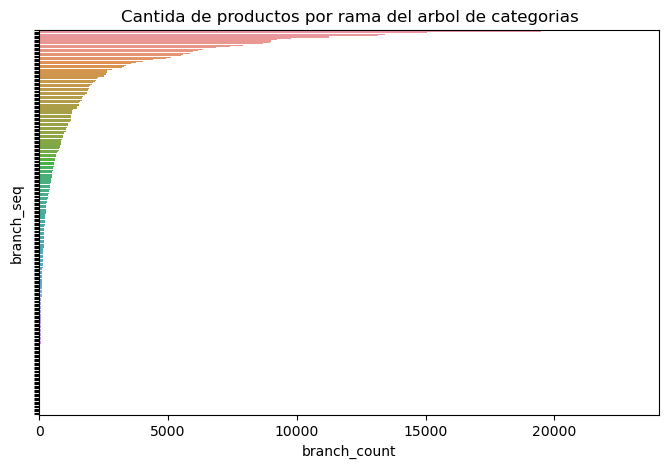

In [34]:
plot_branch_count(branch_count(train_set))

<Figure size 800x500 with 1 Axes>

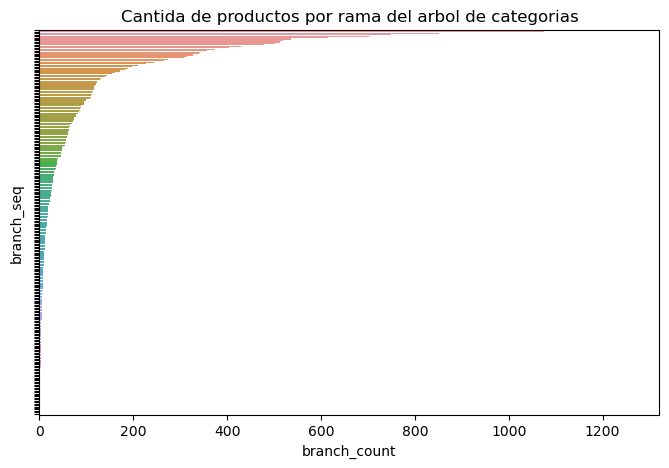

In [35]:
plot_branch_count(branch_count(val_set))

<Figure size 800x500 with 1 Axes>

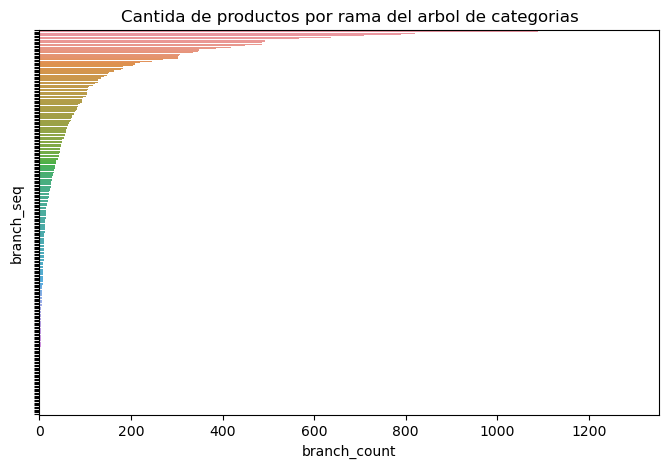

In [36]:
plot_branch_count(branch_count(test_set))

In [37]:
train_set.shape, val_set.shape, test_set.shape

((358641, 11), (19925, 11), (19925, 11))

**Step 8**: Los sets de validación y test deberian tener solo categorias que existan en el set de entrenamiento, de lo contrario, no es posible hacer la predicción.

In [38]:
val_set[val_set['branch_seq'].isin(train_set['branch_seq'].values)].shape

(19925, 11)

In [39]:
test_set[test_set['branch_seq'].isin(train_set['branch_seq'].values)].shape

(19925, 11)

**Step 8**: Guardamos todos los conjuntos preprocesados.

In [40]:
train_set        .to_csv(f'{DATASET_PATH}/train.csv', index=False)
val_set          .to_csv(f'{DATASET_PATH}/val.csv',   index=False)
test_set         .to_csv(f'{DATASET_PATH}/test.csv',  index=False)
filtered_products.to_csv(f'{DATASET_PATH}/all.csv',   index=False)